# Environment Configuration

In [1]:
import os

DEVICE = 'cuda:0'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Preparation

## Download Datasets

Clone the repo containing ATIS and SNIPS and set their paths to be used later.

In [3]:
!git clone https://github.com/BrownFortress/IntentSlotDatasets.git

DATASET_PATHS = {"ATIS": "./IntentSlotDatasets/ATIS/", 
                 "SNIPS": "./IntentSlotDatasets/SNIPS/"}

fatal: destination path 'IntentSlotDatasets' already exists and is not an empty directory.


## Load Data

Load the datasets into a dictionary `dataset[dataset_name][split]` is a list of samples containing an utterance, intent, and a slot.

In [4]:
import os
import json
from pprint import pprint

dataset = dict()

for name, path in DATASET_PATHS.items():
    dataset[name] = dict()
    for split in ["train", "test", "valid"]:
        split_path = os.path.join(path, split + ".json")
        if os.path.exists(split_path):
            with open(split_path) as fp:
                dataset[name][split] = json.load(fp)
                print(name, split, len(dataset[name][split]))

pprint(dataset['ATIS']['train'][0])

ATIS train 4978
ATIS test 893
SNIPS train 13084
SNIPS test 700
SNIPS valid 700
{'intent': 'flight',
 'slots': 'O O O O O B-fromloc.city_name O B-depart_time.time '
          'I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O '
          'B-arrive_time.period_of_day',
 'utterance': 'i want to fly from boston at 838 am and arrive in denver at '
              '1110 in the morning'}


## Lang and Dataset Classes

The `Lang` class stores information about the vocabulary and output labels. Each word/intent/slot label is mapped to an integer. These integers are then fed into the embedding layers of the neural models.

`Dataset` is for dividing the whole dataset into smaller batches.

In [5]:
import torch.utils.data as data

class Lang:
    PAD_TOKEN = '[PAD]'
    UNK_TOKEN = '[UNK]'

    def __init__(self):
        self._vocab = []
        self._word_ids = dict()
        self._intents = []
        self._intent_ids = dict()
        self._slots = []
        self._slot_ids = dict()

    def build_vocab(self, data):
        vocab = set()
        for x in data:
            vocab = vocab.union(set(x['utterance'].split()))
        self._vocab = [Lang.PAD_TOKEN] + list(vocab) + [Lang.UNK_TOKEN]
        self._word_ids = dict((w, i) for i, w in enumerate(self._vocab))

    def build_intents(self, data):
        self._intents = list(set(x['intent'] for x in data))
        self._intent_ids = dict((w, i) for i, w in enumerate(self._intents))

    def build_slots(self, data):
        slots = set()
        for x in data:
            slots = slots.union(set(x['slots'].split()))
        self._slots = list(slots)
        self._slot_ids = dict((w, i) for i, w in enumerate(self._slots))
    
    def get_word_id(self, word):
        if word in self._word_ids:
            return self._word_ids[word]
        else:
            return self._word_ids[Lang.UNK_TOKEN]
    
    def get_intent_id(self, intent):
        return self._intent_ids[intent]
    
    def get_slot_id(self, intent):
        return self._slot_ids[intent]
    
    def get_slot_label(self, i):
        return self._slots[i]

    def get_intent_label(self, i):
        return self._intents[i]
    
    def get_word(self, i):
        return self._vocab[i]
    
    @property
    def vocab_size(self):
        return len(self._vocab)
    
    @property
    def num_intents(self):
        return len(self._intents)
    
    @property
    def num_slots(self):
        return len(self._slots)
    
    @property
    def vocab(self):
        return self._vocab

class Dataset(data.Dataset):

    def __init__(self, data, lang):
        self._x = []
        self._y_intent = []
        self._y_slot = []

        for sample in data:
            utter_ids = list(map(lang.get_word_id, sample['utterance'].split()))
            slot_ids = list(map(lang.get_slot_id, sample['slots'].split()))
            self._x.append(utter_ids)
            self._y_slot.append(slot_ids)
            self._y_intent.append(lang.get_intent_id(sample['intent']))
    
    def __len__(self):
        return len(self._x)

    def __getitem__(self, i):
        x = torch.Tensor(self._x[i])
        y_intent = self._y_intent[i]
        y_slot = torch.Tensor(self._y_slot[i])
        return {'utterance': x, 'intent': y_intent, 'slots': y_slot}

def collate_fn(data):
    def merge(sequences):
        lengths = [len(seq) for seq in sequences]
        max_len = 1 if max(lengths)==0 else max(lengths)
        padded_seqs = torch.LongTensor(len(sequences),max_len).fill_(0)
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq
        padded_seqs = padded_seqs.detach()
        return padded_seqs, lengths

    data.sort(key=lambda x: len(x['utterance']), reverse=True) 
    new_item = {}
    for key in data[0].keys():
        new_item[key] = [d[key] for d in data]
    src_utt, _ = merge(new_item['utterance'])
    y_slots, y_lengths = merge(new_item["slots"])
    intent = torch.LongTensor(new_item["intent"])
    
    src_utt = src_utt.to(DEVICE)
    y_slots = y_slots.to(DEVICE)
    intent = intent.to(DEVICE)
    y_lengths = torch.LongTensor(y_lengths).to(DEVICE)
    
    new_item["utterances"] = src_utt
    new_item["intents"] = intent
    new_item["y_slots"] = y_slots
    new_item["slots_len"] = y_lengths
    return new_item


# Bi-model RNN

Wang, Yu, Yilin Shen, and Hongxia Jin. "A bi-model based rnn semantic frame parsing model for intent detection and slot filling." arXiv preprint [arXiv:1812.10235](https://arxiv.org/abs/1812.10235) (2018).

Original code: https://github.com/ray075hl/Bi-Model-Intent-And-Slot

In [6]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiModelRNN(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_intents, num_slots, vocab_size):
        super(BiModelRNN, self).__init__()
        self._embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self._intent_enc = nn.LSTM(embed_dim, hidden_dim, 2, bidirectional=True)
        self._y_intent1 = nn.Linear(2 * hidden_dim, 2 * hidden_dim)
        self._y_intent2 = nn.Linear(2 * hidden_dim, num_intents)
        self._slot_enc = nn.LSTM(embed_dim, hidden_dim, 2, bidirectional=True)
        self._y_slot1 = nn.Linear(2 * hidden_dim, 2 * hidden_dim)
        self._y_slot2 = nn.Linear(2 * hidden_dim, num_slots)

    def forward(self, input, seq_lens):
        x = self._embed(input).permute(1, 0, 2)
        x = pack_padded_sequence(x, seq_lens.cpu().numpy())
        with torch.no_grad():
            _, (h1, s1) = self._intent_enc(x)
            _, (h2, s2) = self._slot_enc(x)
        y_intent, _ = self._intent_enc(x, (h2, s1))
        y_slot, _ = self._slot_enc(x, (h1, s2))
        y_intent = self._y_intent1(pad_packed_sequence(y_intent)[0])
        y_slot = self._y_slot1(pad_packed_sequence(y_slot)[0])
        self._h_intent, self._s_intent = h1.detach(), s1.detach()
        self._h_slot, self._s_slot = h2.detach(), s2.detach()
        return self._y_intent2(y_intent[-1,:,:]), self._y_slot2(y_slot).permute(1, 2, 0)


# Attention Bi-RNN

Liu, Bing, and Ian Lane. "Attention-based recurrent neural network models for joint intent detection and slot filling." arXiv preprint [arXiv:1609.01454](https://arxiv.org/pdf/1609.01454.pdf) (2016).

In [7]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class AttentionBiRNN(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_intents, num_slots, vocab_size):
        super(AttentionBiRNN, self).__init__()
        self._embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self._blstm = nn.LSTM(embed_dim, hidden_dim, 2, bidirectional=True)
        self._attention = nn.MultiheadAttention(2 * hidden_dim, 4)
        self._y_intent = nn.Linear(2 * hidden_dim, num_intents)
        self._y_slot = nn.Linear(2 * hidden_dim, num_slots)

    def forward(self, x, seq_lens):
        x = self._embed(x).permute(1, 0, 2)
        x = pack_padded_sequence(x, seq_lens.cpu().numpy())
        x, _ = self._blstm(x)
        x, _ = pad_packed_sequence(x)
        x, _ = self._attention(x, x, x)
        return self._y_intent(x[-1,:,:]), self._y_slot(x).permute(1, 2, 0)

# BERT

Chen, Qian, Zhu Zhuo, and Wen Wang. "Bert for joint intent classification and slot filling." arXiv preprint [arXiv:1902.10909](https://arxiv.org/abs/1902.10909) (2019).

In [8]:
import torch.nn as nn
from transformers import BertModel, BertConfig, BertTokenizer

class BERT(nn.Module):

    def __init__(self, num_intents, num_slots, lang):
        super(BERT, self).__init__()
        self._lang = lang
        self._tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', never_split=lang.vocab)
        self._tokenizer.add_tokens(lang.vocab)
        self._bert = BertModel.from_pretrained('bert-base-uncased')
        self._bert.to(DEVICE)
        self._bert.resize_token_embeddings(len(self._tokenizer))
        self._intent = nn.Linear(self._bert.config.hidden_size, num_intents)
        self._slots = nn.Linear(self._bert.config.hidden_size, num_slots)
    
    def _to_text(self, input):
        texts = []
        for sample in input:
            texts.append(' '.join(lang.get_word(i) for i in sample if i > 0))
        return texts
    
    def forward(self, input, seq_lens):
        with torch.no_grad():
            encoding = self._tokenizer(self._to_text(input),
                                        add_special_tokens=True,   
                                        truncation=True,
                                        padding=True,
                                        return_tensors="pt").to(DEVICE)
            bert_output = self._bert(**encoding)
        x_intent = bert_output.pooler_output
        x_slots = bert_output.last_hidden_state[:,:input.size()[1],:]
        return self._intent(x_intent), self._slots(x_slots).permute(0, 2, 1)

# Experimenting

This cell contains code for performing experiments. Modify the `DATASET`, `NUM_EPOCHS` and `model` variables for different setups. Re-run this cell 5 times to gather results for the report.

In [10]:
import numpy as np
from sklearn.metrics import classification_report
import importlib
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

from conlleval import evaluate

DATASET = 'SNIPS'
NUM_EPOCHS = 100

lang = Lang()
lang.build_vocab(dataset[DATASET]['train'] + dataset[DATASET]['test'])
lang.build_intents(dataset[DATASET]['train'] + dataset[DATASET]['test'])
lang.build_slots(dataset[DATASET]['train'] + dataset[DATASET]['test'])

print("Vocab size =", lang.vocab_size)
print("No. intents =", lang.num_intents)
print("No. slots =", lang.num_slots)

train_dataset = Dataset(dataset[DATASET]['train'], lang)
test_dataset = Dataset(dataset[DATASET]['test'], lang)

train_loader = DataLoader(train_dataset, batch_size=128, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

# -------- Un-comment the model you'd like to run and comment the rest -----
model = BiModelRNN(200, 50, lang.num_intents, lang.num_slots, lang.vocab_size)
# model = BERT(lang.num_intents, lang.num_slots, lang)
# model = AttentionBiRNN(200, 50, lang.num_intents, lang.num_slots, lang.vocab_size)
# --------------------------------------------------------------------------

model.train()
model.to(DEVICE)

# -------- Can experiment with other optimizers (e.g. SGD or rmsprop) ------
optimizer = optim.Adam(model.parameters())
# --------------------------------------------------------------------------

intent_loss_fn = nn.CrossEntropyLoss(ignore_index=0)
slot_loss_fn = nn.CrossEntropyLoss()

train_loss = []
test_loss = []
intent_acc = []
slots_f1 = []
for epoch in range(NUM_EPOCHS):
    total_loss_values = []

    # Training loop
    for sample in tqdm(train_loader, desc="Epoch " + str(epoch) + "/" + str(NUM_EPOCHS)):
        optimizer.zero_grad()
        intent, slots = model(sample['utterances'], sample['slots_len'])
        intent_loss = intent_loss_fn(intent, sample['intents'])
        slot_loss = slot_loss_fn(slots, sample['y_slots'])
        # Add + 0.001 * sum(p.pow(2.0).sum() for p in model.parameters()) to loss for L2 regularization
        loss = intent_loss + slot_loss + 0.001 * sum(p.pow(2.0).sum() for p in model.parameters())
        total_loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
    train_loss.append(np.mean(total_loss_values))

    ref_intents = []
    hyp_intents = []
        
    ref_slots = []
    hyp_slots = []

    total_loss_values = []

    # Evaluation loop
    with torch.no_grad():
            for sample in test_loader:
                intent, slots = model(sample['utterances'], sample['slots_len'])
                intent_loss = intent_loss_fn(intent, sample['intents'])
                slot_loss = slot_loss_fn(slots, sample['y_slots'])
                # Add + 0.001 * sum(p.pow(2.0).sum() for p in model.parameters()) to loss for L2 regularization
                loss = intent_loss + slot_loss + 0.001 * sum(p.pow(2.0).sum() for p in model.parameters())
                total_loss_values.append(loss.item())
                out_intents = [lang.get_intent_label(x)
                            for x in torch.argmax(intent, dim=1).tolist()]
                gt_intents = [lang.get_intent_label(x) for x in sample['intents'].tolist()]  
                ref_intents.extend(gt_intents)
                hyp_intents.extend(out_intents) 

                output_slots = torch.argmax(slots, dim=1)
                for id_seq, seq in enumerate(output_slots):
                    length = sample['slots_len'].tolist()[id_seq]
                    utt_ids = sample['utterance'][id_seq][:length].tolist()
                    gt_ids = sample['y_slots'][id_seq].tolist()
                    gt_slots = [lang.get_slot_label(elem) for elem in gt_ids[:length]]
                    utterance = [lang.get_word(int(elem)) for elem in utt_ids]
                    to_decode = seq[:length].tolist()
                    ref_slots.append(gt_slots)
                    tmp_seq = []
                    for id_el, elem in enumerate(to_decode):
                        tmp_seq.append(lang.get_slot_label(elem))
                    hyp_slots.append(tmp_seq)
    test_loss.append(np.mean(total_loss_values))
    f1s = []
    for ref, hyp in zip(ref_slots, hyp_slots):
        _, _, f1 = evaluate(ref, hyp, verbose=False)
        f1s.append(f1)
    slots_f1.append(np.mean(f1s) / 100)

    report_intent = classification_report(ref_intents, hyp_intents, 
                                            zero_division=False, output_dict=True)
    intent_acc.append(report_intent['accuracy'])

    print("Training loss =", train_loss[-1])
    print("Training perplexity =", np.exp(train_loss[-1]))
    print("Validation loss =", test_loss[-1])
    print("Validation perplexity =", np.exp(test_loss[-1]))
    print("Slot filling F1 =", slots_f1[-1])
    print("Intent detection acc. =", intent_acc[-1])

print("F1 =", max(slots_f1))
print("Acc =", max(intent_acc))

Vocab size = 11791
No. intents = 7
No. slots = 72


Epoch 0/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2181.9954336221936
Training perplexity = inf
Validation loss = 2005.4049849076705
Validation perplexity = inf
Slot filling F1 = 0.0
Intent detection acc. = 0.1657142857142857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: overflow encountered in exp


Epoch 1/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 1852.3866606777153
Training perplexity = inf
Validation loss = 1705.6267200816762
Validation perplexity = inf
Slot filling F1 = 0.06426190476190477
Intent detection acc. = 0.12428571428571429


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: overflow encountered in exp


Epoch 2/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 1577.1724000208585
Training perplexity = inf
Validation loss = 1453.4774946732955
Validation perplexity = inf
Slot filling F1 = 0.1582916924345496
Intent detection acc. = 0.16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: overflow encountered in exp


Epoch 3/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 1344.7011943928246
Training perplexity = inf
Validation loss = 1239.7995161576705
Validation perplexity = inf
Slot filling F1 = 0.307545042259328
Intent detection acc. = 0.13142857142857142


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: overflow encountered in exp


Epoch 4/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 1147.3493877521996
Training perplexity = inf
Validation loss = 1058.1153786399148
Validation perplexity = inf
Slot filling F1 = 0.3991324786324787
Intent detection acc. = 0.16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: overflow encountered in exp


Epoch 5/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 979.3101812566368
Training perplexity = inf
Validation loss = 903.2226118607955
Validation perplexity = inf
Slot filling F1 = 0.43963691070833927
Intent detection acc. = 0.12428571428571429


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: overflow encountered in exp


Epoch 6/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 835.9527907880764
Training perplexity = inf
Validation loss = 770.9675181995739
Validation perplexity = inf
Slot filling F1 = 0.4684619983191412
Intent detection acc. = 0.16428571428571428


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: overflow encountered in exp


Epoch 7/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 713.4691535431205
Training perplexity = inf
Validation loss = 657.9246437766335
Validation perplexity = 5.408069950714133e+285
Slot filling F1 = 0.46871273171273176
Intent detection acc. = 0.12428571428571429


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: overflow encountered in exp


Epoch 8/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 608.7151992945995
Training perplexity = 2.2995989638107517e+264
Validation loss = 561.1845536665483
Validation perplexity = 5.240285958072329e+243
Slot filling F1 = 0.475891156462585
Intent detection acc. = 0.1657142857142857


Epoch 9/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 519.0693015681887
Training perplexity = 2.6849326518287455e+225
Validation loss = 478.40203579989344
Validation perplexity = 5.85280802367676e+207
Slot filling F1 = 0.48302958152958153
Intent detection acc. = 0.16


Epoch 10/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 442.338730006542
Training perplexity = 1.274293811312249e+192
Validation loss = 407.54979913884944
Validation perplexity = 9.922677279174553e+176
Slot filling F1 = 0.4826590393733251
Intent detection acc. = 0.16


Epoch 11/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 376.66053223841396
Training perplexity = 3.8158447942193695e+163
Validation loss = 346.875038840554
Validation perplexity = 4.425020412515674e+150
Slot filling F1 = 0.5185672026386312
Intent detection acc. = 0.12428571428571429


Epoch 12/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 320.44920482450317
Training perplexity = 1.476798986272208e+139
Validation loss = 294.9699429598722
Validation perplexity = 1.2700433790689006e+128
Slot filling F1 = 0.5240052566481137
Intent detection acc. = 0.16


Epoch 13/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 272.34936464180066
Training perplexity = 1.9046983860357953e+118
Validation loss = 250.56520219282672
Validation perplexity = 6.593024191993913e+108
Slot filling F1 = 0.5093952793238508
Intent detection acc. = 0.13142857142857142


Epoch 14/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 231.24023644901015
Training perplexity = 2.6690621328631573e+100
Validation loss = 212.62924333052203
Validation perplexity = 2.206515942775518e+92
Slot filling F1 = 0.5221887239744383
Intent detection acc. = 0.16428571428571428


Epoch 15/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 196.10633938983807
Training perplexity = 1.4719771327128245e+85
Validation loss = 180.22682189941406
Validation perplexity = 1.868590953198328e+78
Slot filling F1 = 0.5074420024420024
Intent detection acc. = 0.1657142857142857


Epoch 16/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 166.12016311201077
Training perplexity = 1.3965940016294074e+72
Validation loss = 152.60945545543325
Validation perplexity = 1.894280944714861e+66
Slot filling F1 = 0.4701678004535148
Intent detection acc. = 0.18857142857142858


Epoch 17/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 140.54624731563828
Training perplexity = 1.0925961387824772e+61
Validation loss = 129.01568880948153
Validation perplexity = 1.073499209344219e+56
Slot filling F1 = 0.5294771498342927
Intent detection acc. = 0.16


Epoch 18/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 118.76280234623881
Training perplexity = 3.7846847856581137e+51
Validation loss = 108.99607432972302
Validation perplexity = 2.1696697325829846e+47
Slot filling F1 = 0.49807763664906524
Intent detection acc. = 0.13142857142857142


Epoch 19/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 100.24014452591683
Training perplexity = 3.4177605517824976e+43
Validation loss = 91.91318303888494
Validation perplexity = 8.267766600115263e+39
Slot filling F1 = 0.5409318697175841
Intent detection acc. = 0.12428571428571429


Epoch 20/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 84.4955456928142
Training perplexity = 4.965342832829262e+36
Validation loss = 77.44591799649325
Validation perplexity = 4.308586653389166e+33
Slot filling F1 = 0.5435024737167594
Intent detection acc. = 0.16


Epoch 21/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 71.15912902239457
Training perplexity = 8.017095767744756e+30
Validation loss = 65.18062383478338
Validation perplexity = 2.030417081770427e+28
Slot filling F1 = 0.5484553700267987
Intent detection acc. = 0.13142857142857142


Epoch 22/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 59.85153387125256
Training perplexity = 9.844437219871233e+25
Validation loss = 54.82975248856978
Validation perplexity = 6.490212998745032e+23
Slot filling F1 = 0.5422101469958612
Intent detection acc. = 0.16


Epoch 23/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 50.3054620687244
Training perplexity = 7.036951957615221e+21
Validation loss = 46.05469443581321
Validation perplexity = 1.0029970581576706e+20
Slot filling F1 = 0.5580071436500008
Intent detection acc. = 0.13142857142857142


Epoch 24/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 42.25701489494842
Training perplexity = 2.2489944856351232e+18
Validation loss = 38.69365241310813
Validation perplexity = 6.374406095429302e+16
Slot filling F1 = 0.5680465685108541
Intent detection acc. = 0.16428571428571428


Epoch 25/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 35.4771482226918
Training perplexity = 2555816719046959.5
Validation loss = 32.48375909978693
Validation perplexity = 128090620215246.06
Slot filling F1 = 0.567025728240014
Intent detection acc. = 0.16


Epoch 26/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 29.770246524255253
Training perplexity = 8492856584411.268
Validation loss = 27.27318000793457
Validation perplexity = 699184160954.8704
Slot filling F1 = 0.5662779918494204
Intent detection acc. = 0.16428571428571428


Epoch 27/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 25.00074681032051
Training perplexity = 72058693423.82764
Validation loss = 22.907472957264293
Validation perplexity = 8883602132.623621
Slot filling F1 = 0.5740994243851386
Intent detection acc. = 0.16


Epoch 28/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 21.00086019571545
Training perplexity = 1319950662.1874788
Validation loss = 19.303257855502043
Validation perplexity = 241712087.67775655
Slot filling F1 = 0.5618598544312828
Intent detection acc. = 0.16428571428571428


Epoch 29/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 17.677497919323375
Training perplexity = 47559775.97088455
Validation loss = 16.23587452281605
Validation perplexity = 11249953.157362683
Slot filling F1 = 0.5994709972567115
Intent detection acc. = 0.18857142857142858


Epoch 30/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 14.900340774684276
Training perplexity = 2958937.397992636
Validation loss = 13.714423006231135
Validation perplexity = 903853.8954465536
Slot filling F1 = 0.6134786483357912
Intent detection acc. = 0.16


Epoch 31/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 12.60754917663278
Training perplexity = 298805.81004081
Validation loss = 11.628430279818447
Validation perplexity = 112243.9918913113
Slot filling F1 = 0.6156181120466835
Intent detection acc. = 0.18857142857142858


Epoch 32/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 10.70820049174781
Training perplexity = 44721.090462144864
Validation loss = 9.923795179887252
Validation perplexity = 20410.30460281436
Slot filling F1 = 0.6006925376211091
Intent detection acc. = 0.12428571428571429


Epoch 33/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 9.142648233950716
Training perplexity = 9345.481411300158
Validation loss = 8.483191230080344
Validation perplexity = 4832.8480443399
Slot filling F1 = 0.6165076272933415
Intent detection acc. = 0.12428571428571429


Epoch 34/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 7.844588131580538
Training perplexity = 2551.886405647894
Validation loss = 7.323286403309215
Validation perplexity = 1515.1752734671963
Slot filling F1 = 0.6013514342800057
Intent detection acc. = 0.13142857142857142


Epoch 35/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 6.780700197497618
Training perplexity = 880.6851618150394
Validation loss = 6.379873925989324
Validation perplexity = 589.8533377945075
Slot filling F1 = 0.6123877868163582
Intent detection acc. = 0.16


Epoch 36/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 5.91432912141374
Training perplexity = 370.3057891281443
Validation loss = 5.573375485160134
Validation perplexity = 263.32143840534843
Slot filling F1 = 0.6105795632938491
Intent detection acc. = 0.1657142857142857


Epoch 37/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 5.204141672375132
Training perplexity = 182.02456898248573
Validation loss = 5.006357149644331
Validation perplexity = 149.3596490657789
Slot filling F1 = 0.563699237270666
Intent detection acc. = 0.16


Epoch 38/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 4.649831873699299
Training perplexity = 104.56740356842074
Validation loss = 4.432706702839244
Validation perplexity = 84.15890204316499
Slot filling F1 = 0.640992745349888
Intent detection acc. = 0.12428571428571429


Epoch 39/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 4.174348176104351
Training perplexity = 64.99745895323629
Validation loss = 4.0265044515783135
Validation perplexity = 56.06459182953036
Slot filling F1 = 0.6489985887128743
Intent detection acc. = 0.12428571428571429


Epoch 40/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 3.79997307351492
Training perplexity = 44.699980863728335
Validation loss = 3.6824592460285532
Validation perplexity = 39.74401429661647
Slot filling F1 = 0.6291852710781282
Intent detection acc. = 0.1657142857142857


Epoch 41/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 3.4991759929842163
Training perplexity = 33.08817583335017
Validation loss = 3.3947479724884033
Validation perplexity = 29.807140308815715
Slot filling F1 = 0.627782645925503
Intent detection acc. = 0.16428571428571428


Epoch 42/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 3.2465491757809537
Training perplexity = 25.701495369213106
Validation loss = 3.2142182263461025
Validation perplexity = 24.883830781744173
Slot filling F1 = 0.6254211740640312
Intent detection acc. = 0.16


Epoch 43/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 3.062236049800243
Training perplexity = 21.375299999747572
Validation loss = 3.066158793189309
Validation perplexity = 21.459314492424788
Slot filling F1 = 0.6331760461760463
Intent detection acc. = 0.1657142857142857


Epoch 44/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.9174785590866237
Training perplexity = 18.494595589093286
Validation loss = 2.897617058320479
Validation perplexity = 18.13088900012417
Slot filling F1 = 0.6340858189429618
Intent detection acc. = 0.18857142857142858


Epoch 45/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.7826023634197643
Training perplexity = 16.161023127268248
Validation loss = 2.772593845020641
Validation perplexity = 16.0000819647037
Slot filling F1 = 0.6537308088736661
Intent detection acc. = 0.16


Epoch 46/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.689826601917304
Training perplexity = 14.729121697538146
Validation loss = 2.717653426257047
Validation perplexity = 15.144742261218616
Slot filling F1 = 0.6279618737938065
Intent detection acc. = 0.16


Epoch 47/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.6129484523847264
Training perplexity = 13.63920617468331
Validation loss = 2.6947353969920766
Validation perplexity = 14.80160168674839
Slot filling F1 = 0.6049978275692562
Intent detection acc. = 0.12428571428571429


Epoch 48/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.5618631006444543
Training perplexity = 12.95994051011196
Validation loss = 2.5649440722032026
Validation perplexity = 12.999931291823227
Slot filling F1 = 0.669872151657866
Intent detection acc. = 0.16


Epoch 49/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.5113293615359704
Training perplexity = 12.321298638704237
Validation loss = 2.5235207080841064
Validation perplexity = 12.472431243426051
Slot filling F1 = 0.6760537954109382
Intent detection acc. = 0.12428571428571429


Epoch 50/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.472044046642711
Training perplexity = 11.846637199118838
Validation loss = 2.4987506649710913
Validation perplexity = 12.167283447750647
Slot filling F1 = 0.6616852829709973
Intent detection acc. = 0.13142857142857142


Epoch 51/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.4433810294253155
Training perplexity = 11.511897081341
Validation loss = 2.5237390344793145
Validation perplexity = 12.475154601658582
Slot filling F1 = 0.625063492063492
Intent detection acc. = 0.16


Epoch 52/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.436692615157192
Training perplexity = 11.435157663235692
Validation loss = 2.471449938687411
Validation perplexity = 11.839601108021096
Slot filling F1 = 0.6659130393416107
Intent detection acc. = 0.12428571428571429


Epoch 53/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.400311884370822
Training perplexity = 11.02661487324972
Validation loss = 2.448362783952193
Validation perplexity = 11.569389614679519
Slot filling F1 = 0.6579536614179472
Intent detection acc. = 0.13142857142857142


Epoch 54/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.390602766888813
Training perplexity = 10.920074218819044
Validation loss = 2.443567384373058
Validation perplexity = 11.514042580225968
Slot filling F1 = 0.6673732140874997
Intent detection acc. = 0.13142857142857142


Epoch 55/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.383625981877151
Training perplexity = 10.844152361880855
Validation loss = 2.4077209776098076
Validation perplexity = 11.108615490951102
Slot filling F1 = 0.6884698951841809
Intent detection acc. = 0.16


Epoch 56/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.370510441585652
Training perplexity = 10.702854071834098
Validation loss = 2.4319250150160356
Validation perplexity = 11.380769158289137
Slot filling F1 = 0.664207054849912
Intent detection acc. = 0.1657142857142857


Epoch 57/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.362727336513186
Training perplexity = 10.619875966551866
Validation loss = 2.4199562072753906
Validation perplexity = 11.245366838845387
Slot filling F1 = 0.665737778094921
Intent detection acc. = 0.18857142857142858


Epoch 58/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.365545689480976
Training perplexity = 10.649848742591152
Validation loss = 2.4071379574862393
Validation perplexity = 11.102140832186471
Slot filling F1 = 0.6755566021280308
Intent detection acc. = 0.12428571428571429


Epoch 59/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.360525823333888
Training perplexity = 10.596521886239238
Validation loss = 2.403732191432606
Validation perplexity = 11.064393852994092
Slot filling F1 = 0.6699348112205256
Intent detection acc. = 0.13142857142857142


Epoch 60/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.356084825923142
Training perplexity = 10.549567100193117
Validation loss = 2.4243217598308218
Validation perplexity = 11.294566392266281
Slot filling F1 = 0.6634591836734693
Intent detection acc. = 0.16428571428571428


Epoch 61/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3524184226989746
Training perplexity = 10.510958953130034
Validation loss = 2.3881903995167124
Validation perplexity = 10.893762737312407
Slot filling F1 = 0.6763837353123067
Intent detection acc. = 0.1657142857142857


Epoch 62/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3516649204550437
Training perplexity = 10.503041905104297
Validation loss = 2.3988729173486885
Validation perplexity = 11.01075934860579
Slot filling F1 = 0.6664728525442811
Intent detection acc. = 0.16


Epoch 63/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3508420106276726
Training perplexity = 10.494402403956038
Validation loss = 2.387903343547474
Validation perplexity = 10.890636066477429
Slot filling F1 = 0.6846836338264909
Intent detection acc. = 0.12428571428571429


Epoch 64/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3444119958044256
Training perplexity = 10.427139722704542
Validation loss = 2.411089290272106
Validation perplexity = 11.146095868548878
Slot filling F1 = 0.6724429300857873
Intent detection acc. = 0.1657142857142857


Epoch 65/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3453032623216945
Training perplexity = 10.436437225871446
Validation loss = 2.3859559405933726
Validation perplexity = 10.869448246936727
Slot filling F1 = 0.6877963306534735
Intent detection acc. = 0.16428571428571428


Epoch 66/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.347724609004641
Training perplexity = 10.461738077234946
Validation loss = 2.3938613588159736
Validation perplexity = 10.955716324512856
Slot filling F1 = 0.6746660482374769
Intent detection acc. = 0.1657142857142857


Epoch 67/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3368265628814697
Training perplexity = 10.34834457921191
Validation loss = 2.388228329745206
Validation perplexity = 10.894175948058727
Slot filling F1 = 0.6847981066552495
Intent detection acc. = 0.12428571428571429


Epoch 68/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.343977261515497
Training perplexity = 10.422607672721773
Validation loss = 2.391393553126942
Validation perplexity = 10.928713078526131
Slot filling F1 = 0.6865960547389119
Intent detection acc. = 0.13142857142857142


Epoch 69/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.337339716050231
Training perplexity = 10.353656227752248
Validation loss = 2.376348712227561
Validation perplexity = 10.765522991595674
Slot filling F1 = 0.6939090433376148
Intent detection acc. = 0.12428571428571429


Epoch 70/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.337823636323503
Training perplexity = 10.358667784402476
Validation loss = 2.3891474333676426
Validation perplexity = 10.904193427481673
Slot filling F1 = 0.6697374768089054
Intent detection acc. = 0.1657142857142857


Epoch 71/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3364549771095944
Training perplexity = 10.344499995944268
Validation loss = 2.398344711823897
Validation perplexity = 11.004944940422154
Slot filling F1 = 0.6777716252001966
Intent detection acc. = 0.18857142857142858


Epoch 72/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3466979971209776
Training perplexity = 10.451003443695061
Validation loss = 2.3894459767775102
Validation perplexity = 10.907449288553119
Slot filling F1 = 0.6927700474129046
Intent detection acc. = 0.16


Epoch 73/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.334944794478926
Training perplexity = 10.328889701891715
Validation loss = 2.391058921813965
Validation perplexity = 10.925056600739618
Slot filling F1 = 0.7056604744461887
Intent detection acc. = 0.13142857142857142


Epoch 74/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.333624992555785
Training perplexity = 10.315266605271288
Validation loss = 2.403104543685913
Validation perplexity = 11.05745149003088
Slot filling F1 = 0.6736863136863137
Intent detection acc. = 0.1657142857142857


Epoch 75/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3351509015537
Training perplexity = 10.331018778535181
Validation loss = 2.394271590492942
Validation perplexity = 10.96021162838803
Slot filling F1 = 0.6752795537795538
Intent detection acc. = 0.13142857142857142


Epoch 76/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.334692242076096
Training perplexity = 10.32628144535353
Validation loss = 2.4278216145255347
Validation perplexity = 11.33416498772391
Slot filling F1 = 0.6721090338233195
Intent detection acc. = 0.16


Epoch 77/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.337728509625185
Training perplexity = 10.35768244540394
Validation loss = 2.374842557040128
Validation perplexity = 10.749320647981316
Slot filling F1 = 0.7067466501752215
Intent detection acc. = 0.16


Epoch 78/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3341583511204393
Training perplexity = 10.320769808521737
Validation loss = 2.3802198496731846
Validation perplexity = 10.807278579435254
Slot filling F1 = 0.696101319315605
Intent detection acc. = 0.16


Epoch 79/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.328437562127715
Training perplexity = 10.261895426729524
Validation loss = 2.3980219580910425
Validation perplexity = 11.001393626493517
Slot filling F1 = 0.689809174952032
Intent detection acc. = 0.18857142857142858


Epoch 80/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.332472310482877
Training perplexity = 10.303383232569225
Validation loss = 2.3909413164312188
Validation perplexity = 10.923771830825974
Slot filling F1 = 0.6778382807668522
Intent detection acc. = 0.13142857142857142


Epoch 81/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3231385564341127
Training perplexity = 10.207661404537442
Validation loss = 2.392080783843994
Validation perplexity = 10.936226207182248
Slot filling F1 = 0.6870084518655948
Intent detection acc. = 0.18857142857142858


Epoch 82/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3268324240897464
Training perplexity = 10.245436880691313
Validation loss = 2.373256033117121
Validation perplexity = 10.732280114798334
Slot filling F1 = 0.6969991754277468
Intent detection acc. = 0.12428571428571429


Epoch 83/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3273254528786373
Training perplexity = 10.250489421449938
Validation loss = 2.4093615141781894
Validation perplexity = 11.126854537709036
Slot filling F1 = 0.6943239538239537
Intent detection acc. = 0.16


Epoch 84/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3227819123314424
Training perplexity = 10.204021551400116
Validation loss = 2.379530256444758
Validation perplexity = 10.799828522358842
Slot filling F1 = 0.6928814677386106
Intent detection acc. = 0.12428571428571429


Epoch 85/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3276449985874508
Training perplexity = 10.253765444749519
Validation loss = 2.385622501373291
Validation perplexity = 10.865824550765337
Slot filling F1 = 0.7155612562041134
Intent detection acc. = 0.12428571428571429


Epoch 86/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3292961444669555
Training perplexity = 10.270709892340822
Validation loss = 2.3997386585582388
Validation perplexity = 11.020295944238592
Slot filling F1 = 0.703877923663638
Intent detection acc. = 0.1657142857142857


Epoch 87/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3278715286440064
Training perplexity = 10.25608849392592
Validation loss = 2.3793407570232046
Validation perplexity = 10.79778215499982
Slot filling F1 = 0.6936589680161108
Intent detection acc. = 0.16428571428571428


Epoch 88/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.327106779061475
Training perplexity = 10.248248152862677
Validation loss = 2.3872365951538086
Validation perplexity = 10.883377172570949
Slot filling F1 = 0.7143614322185751
Intent detection acc. = 0.16428571428571428


Epoch 89/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3265327435095333
Training perplexity = 10.24236698223982
Validation loss = 2.3748375935987993
Validation perplexity = 10.749267294491366
Slot filling F1 = 0.7110203288774717
Intent detection acc. = 0.16


Epoch 90/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.320307078870755
Training perplexity = 10.178799520467509
Validation loss = 2.4063360691070557
Validation perplexity = 11.093241722992069
Slot filling F1 = 0.6872048467405609
Intent detection acc. = 0.1657142857142857


Epoch 91/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3295135405457135
Training perplexity = 10.27294294711736
Validation loss = 2.4173817851326684
Validation perplexity = 11.216453750668453
Slot filling F1 = 0.685934581291724
Intent detection acc. = 0.1657142857142857


Epoch 92/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3276316911271473
Training perplexity = 10.25362899408081
Validation loss = 2.3790495178916236
Validation perplexity = 10.794637876192738
Slot filling F1 = 0.6993584827870543
Intent detection acc. = 0.12428571428571429


Epoch 93/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3179651464073405
Training perplexity = 10.154989351218632
Validation loss = 2.3903669010509145
Validation perplexity = 10.917498850096202
Slot filling F1 = 0.6981224489795917
Intent detection acc. = 0.16428571428571428


Epoch 94/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3217541963151356
Training perplexity = 10.193540101920297
Validation loss = 2.3919709595766934
Validation perplexity = 10.935025210102527
Slot filling F1 = 0.701953823953824
Intent detection acc. = 0.12428571428571429


Epoch 95/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3168733999567124
Training perplexity = 10.143908727354752
Validation loss = 2.3794162056662818
Validation perplexity = 10.798596863745606
Slot filling F1 = 0.7083083900226756
Intent detection acc. = 0.16


Epoch 96/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.316189557603262
Training perplexity = 10.136974264247472
Validation loss = 2.379209973595359
Validation perplexity = 10.796370076376713
Slot filling F1 = 0.7006630908773767
Intent detection acc. = 0.16


Epoch 97/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3394639978131044
Training perplexity = 10.375673688221175
Validation loss = 2.426460461183028
Validation perplexity = 11.318747946025576
Slot filling F1 = 0.6561967635539062
Intent detection acc. = 0.16


Epoch 98/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.33297737130841
Training perplexity = 10.308588382158378
Validation loss = 2.3929944038391113
Validation perplexity = 10.94622232774875
Slot filling F1 = 0.6914551638837352
Intent detection acc. = 0.16428571428571428


Epoch 99/100:   0%|          | 0/103 [00:00<?, ?it/s]

Training loss = 2.3280192069636967
Training perplexity = 10.257603207683738
Validation loss = 2.388210968537764
Validation perplexity = 10.89398681365199
Slot filling F1 = 0.7147705151990867
Intent detection acc. = 0.16
F1 = 0.7155612562041134
Acc = 0.18857142857142858


In [11]:
for ref, hyp in zip(ref_slots, hyp_slots):
        evaluate(ref, hyp, verbose=True)

processed 20 tokens with 2 phrases; found: 3 phrases; correct: 1.
accuracy:  90.00%; (non-O)
accuracy:  95.00%; precision:  33.33%; recall:  50.00%; FB1:  40.00
          country: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
   geographic_poi: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
        timeRange: precision: 100.00%; recall: 100.00%; FB1: 100.00  1
processed 18 tokens with 4 phrases; found: 4 phrases; correct: 3.
accuracy:  75.00%; (non-O)
accuracy:  94.44%; precision:  75.00%; recall:  75.00%; FB1:  75.00
party_size_number: precision: 100.00%; recall: 100.00%; FB1: 100.00  1
              poi: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
  restaurant_type: precision: 100.00%; recall: 100.00%; FB1: 100.00  1
 spatial_relation: precision:  50.00%; recall: 100.00%; FB1:  66.67  2
processed 16 tokens with 4 phrases; found: 4 phrases; correct: 4.
accuracy: 100.00%; (non-O)
accuracy: 100.00%; precision: 100.00%; recall: 100.00%; FB1: 100.00
             city: p

# Plots

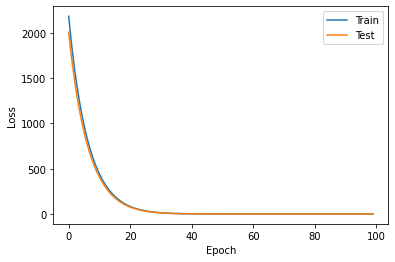

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.legend()
plt.show()

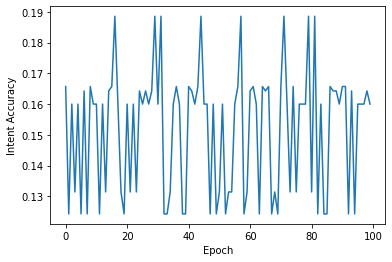

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Intent Accuracy')
plt.plot(intent_acc)
plt.show()

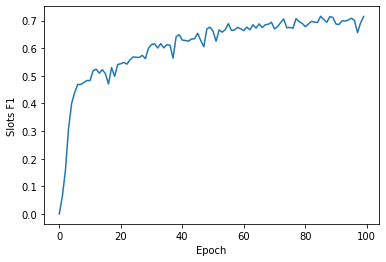

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Slots F1')
plt.plot(slots_f1)
plt.show()